In [62]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [63]:
pd.options.display.max_columns = None

In [64]:
train_og = pd.read_csv('data/training_set_census.csv', skipinitialspace = True)
test_og = pd.read_csv('data/testing_set_census.csv', skipinitialspace = True)

In [65]:
train = train_og.copy()

In [66]:
test = test_og.copy()

In [67]:
print(train.shape)
test.shape

(200000, 42)


(50000, 41)

In [68]:
train.head(1)

,Unnamed: 0,age,class_of_worker,industry_code,occupation_code,education,wage_per_hour,enrolled_in_edu_inst_lastwk,marital_status,major_industry_code,major_occupation_code,race,hispanic_origin,sex,member_of_labor_union,reason_for_unemployment,full_parttime_employment_stat,capital_gains,capital_losses,dividend_from_Stocks,tax_filer_status,region_of_previous_residence,state_of_previous_residence,d_household_family_stat,d_household_summary,migration_msa,migration_reg,migration_within_reg,live_1_year_ago,migration_sunbelt,num_person_Worked_employer,family_members_under_18,country_father,country_mother,country_self,citizenship,business_or_self_employed,fill_questionnaire_veteran_admin,veterans_benefits,weeks_worked_in_year,year,income_level
0,0,23,Private,43,22,Some college but no degree,0,College or university,Never married,Education,Adm support including clerical,White,All other,Male,Not in universe,Not in universe,Full-time schedules,0,0,0,Single,Not in universe,Not in universe,Child 18+ never marr Not in a subfamily,Child 18 or older,NaN,NaN,NaN,Not in universe under 1 year old,NaN,4,Not in universe,Peru,Peru,United-States,Native- Born in the United States,0,Not in universe,2,30,95,0


In [69]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 42 columns):
 #   Column                            Non-Null Count   Dtype 
---  ------                            --------------   ----- 
 0   Unnamed: 0                        200000 non-null  int64 
 1   age                               200000 non-null  int64 
 2   class_of_worker                   200000 non-null  object
 3   industry_code                     200000 non-null  int64 
 4   occupation_code                   200000 non-null  int64 
 5   education                         200000 non-null  object
 6   wage_per_hour                     200000 non-null  int64 
 7   enrolled_in_edu_inst_lastwk       200000 non-null  object
 8   marital_status                    200000 non-null  object
 9   major_industry_code               200000 non-null  object
 10  major_occupation_code             200000 non-null  object
 11  race                              200000 non-null  object
 12  hi

In [70]:
train = train.replace('Not in universe',np.nan)
test = test.replace('Not in universe', np.nan)

In [71]:
train.isnull().sum()

Unnamed: 0                               0
age                                      0
class_of_worker                      99144
industry_code                            0
occupation_code                          0
education                                0
wage_per_hour                            0
enrolled_in_edu_inst_lastwk         187457
marital_status                           0
major_industry_code                      0
major_occupation_code                99570
race                                     0
hispanic_origin                        855
sex                                      0
member_of_labor_union               180812
reason_for_unemployment             193894
full_parttime_employment_stat            0
capital_gains                            0
capital_losses                           0
dividend_from_Stocks                     0
tax_filer_status                         0
region_of_previous_residence        184299
state_of_previous_residence         184776
d_household

# Data cleaning

In [72]:
# Columns to drop
def cols_deleted(a):
    cols_to_drop = ['Unnamed: 0','migration_sunbelt','state_of_previous_residence','region_of_previous_residence',
                    'year','member_of_labor_union','reason_for_unemployment','fill_questionnaire_veteran_admin',
                   'class_of_worker','family_members_under_18','enrolled_in_edu_inst_lastwk','major_occupation_code']
    a.drop(columns = cols_to_drop, inplace = True)
    return a

train = cols_deleted(train)
test = cols_deleted(test)

In [73]:
train.business_or_self_employed = train.business_or_self_employed.astype('str')
train.veterans_benefits = train.veterans_benefits.astype('str')

In [74]:
test.veterans_benefits = test.veterans_benefits.astype('str')
test.business_or_self_employed = test.business_or_self_employed.astype('str')

In [75]:
cols = train.columns.tolist()
cat_cols = train.select_dtypes(include = 'object').columns.to_list()
num_cols = train.select_dtypes(include = 'int64').columns.to_list()

In [76]:
for col in test.columns.tolist():
    if 'country' in col:
        test[col].fillna(test[col].mode()[0], inplace = True)

In [77]:
def hispanic_origin_clean(df):
    df.loc[(df.country_father == 'Cuba') | (df.country_mother == 'Cuba'),'hispanic_origin']='Cuban'
    df.loc[(df.country_father == 'Dominican-Republic') | (df.country_mother == 'Dominican-Republic'),'hispanic_origin']='Other Spanish'
    df.loc[(df.country_father == 'Haiti') | (df.country_mother == 'Haiti'),'hispanic_origin']='Other Spanish'
    df.loc[(df.country_father == 'Mexico') | (df.country_mother == 'Mexico'),'hispanic_origin']='Mexican (Mexicano)'
    df.hispanic_origin.fillna('All other', inplace = True)
    return df

train = hispanic_origin_clean(train)
test = hispanic_origin_clean(test)

### Changed hispanic origin for people whose parent's countries are any of the following:
### Puerto-rico, Mexico, Haiti, Dominican-Republican

In [78]:
def migration_data_cleaning(df):
    for col in df.columns.tolist():
        if 'migration' in col:
            df[col] = df[col].replace(['?',np.nan,'Not in universe'],'Nonmover')
    
    return df

train = migration_data_cleaning(train)
test = migration_data_cleaning(test)

In [79]:
train.dropna(subset = ['country_father','country_mother','country_self'], inplace = True)

# Data visualization

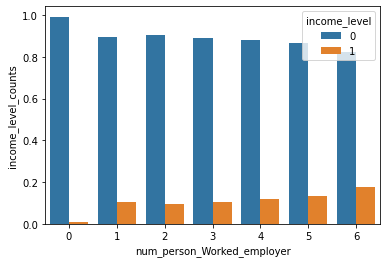

In [80]:
def bar_plot_visualize_income_level(column: str) -> None:
    bar_data = train.groupby(by = column)['income_level'].value_counts(normalize = True).to_frame()
    bar_data = bar_data.rename(columns = {'income_level' : 'income_level_counts'})
    bar_data = bar_data.reset_index()
    sns.barplot(data = bar_data, x = column, y = 'income_level_counts', hue = 'income_level')
    
bar_plot_visualize_income_level('num_person_Worked_employer')

<AxesSubplot:xlabel='income_level', ylabel='age'>

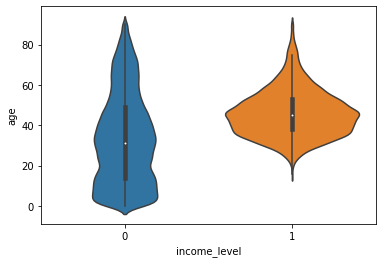

In [81]:
sns.violinplot(data = train, x = 'income_level', y = 'age')

<AxesSubplot:>

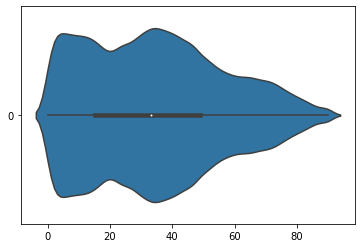

In [82]:
sns.violinplot(data = train['age'], orient = 'h')

# Data transformation

In [83]:
train_end = train.shape[0]
train_end

194387

In [84]:
full_df = pd.concat([train, test])
full_df.shape

(244387, 30)

In [85]:
full_df = pd.get_dummies(full_df, drop_first = True)

In [86]:
full_df.shape

(244387, 281)

In [87]:
train = full_df[:train_end]
test = full_df[train_end:]

In [88]:
train.shape

(194387, 281)

# Model training